# Cluster Analysis

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from addutils import css_notebook
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
css_notebook()

In [3]:
import bokeh.plotting as bk
from bokeh import palettes
bk.output_notebook()

Loading BokehJS ...

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook

## 1 Introduction

What is Clustering? *Given a set of data points, partition them into groups (clusters) containing very similar data points.*

This is a rough description of what clustering, for example it does not define what is the **number of clusters**, or what we mean for **similar**. 

Clustering has many applications, for example: data summarization, customer segmentation, social network analysis, preprocessing step for classification or outlier detection.

There are many kind of clustering algorithm we will briefly sketch the main ideas of each typology, but first we will briefly define what is **similarity (or distance)**.

### 1.1 Distances

Given two objects $O_1$ and $O_2$, determine a value of the similarity $Sim(O_1 , O_2)$ (or distance $Dist(O_1, O_2))$ between the two objects. 

In similarity functions, larger values imply greater similarity, whereas in distance functions, smaller values imply greater similarity. In some domains, for example when talking about spatial data, it is more natural to talk about distance function, while in other domains, for example when we analyse text data. The choice of the distance function is very important for the quality of the result.

The most common distance function for **quantitative data** is the $L_p$*-norm*, given two data points $X = (x_1, \ldots, x_n)$ and $Y = (y_1, \ldots, y_n)$ it is defined as:
$$ Dist(X,Y) = \Bigg(\sum_{i=1}^d \mid x_i - y_i \mid^p \Bigg)^{1/p}$$
Two special cases are the Euclidean ($p=2$) and Manhattan ($p=1$). The Euclidean distance is the straight line between two points:
<img src="images/Euclidean_distance.png" alt="Euclidean Distance"  height="400" width="400">
The Manhattan distance is the "city block" distance in a region where the street are arranged as rectangular blocks:
<img src="images/Manhattan_distance.png" alt="Manhattan Distance" height="400" width="400">
These two distances are the most popular and widely used distances.

## 2 Representative-Based Algorithms

This is the symplest way of clustering, because this algorithms rely directly on the notion of distance (or similarity) to cluster data points. Each cluster is represented by a representative, that could be a function of the points or a point in the cluster. Finding a good clustering here, means finding a good set of representatives. With a good set of representatives and the distance function it is possible to assign points to the closest representative.

### 2.1 KMeans

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from X, although they live in the same space. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum of squared criterion:

$\sum_{i=0}^{n}\min_{\mu_j \in C}(\|x_j - \mu_i\|^2)$

Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:
* Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
* Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

<IPython.core.display.Javascript object>


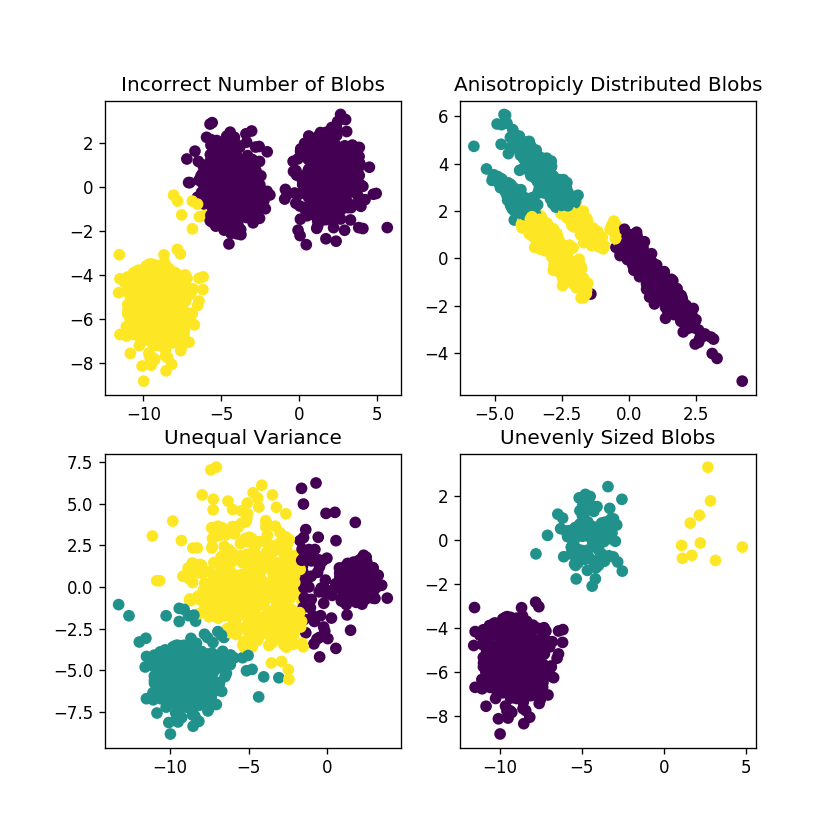

In [5]:
plt.figure(figsize=(7, 7))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

### 2.1 Silhouette Plot

First of all we will create a synthetic dataset that we will use for each example throughout the notebook.

In [6]:
n_samples = 1500
n_features = 10
random_state = 0
X, _ = make_blobs(n_samples=n_samples, n_features=n_features, 
                  random_state=random_state, centers=4, cluster_std=0.4)
print(X.shape)

(1500, 10)


In [7]:
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
Y = tsne.fit_transform(X)
print(Y.shape)

(1500, 2)


In [8]:
fig = bk.figure(plot_width=750, 
                plot_height=450,
                title="Data")
#fig.scatter(Y[:,0], Y[:,1], fill_color=[pal[i] for i in y_pred], line_color=None)
fig.scatter(Y[:,0], Y[:,1], line_color=None)
bk.show(fig)

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 4, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 3.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 2 sub clusters into one big cluster. However when the n_clusters is equal to 3, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

<IPython.core.display.Javascript object>


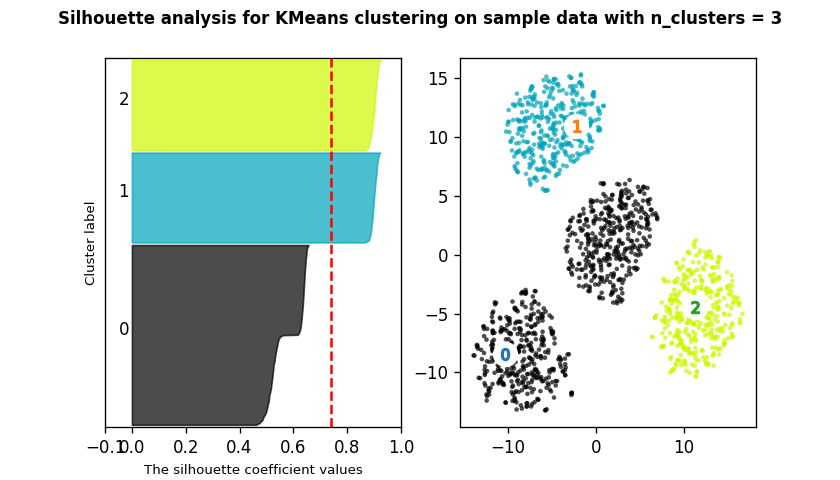

For n_clusters = 3 The average silhouette_score is : 0.739283092276


<IPython.core.display.Javascript object>


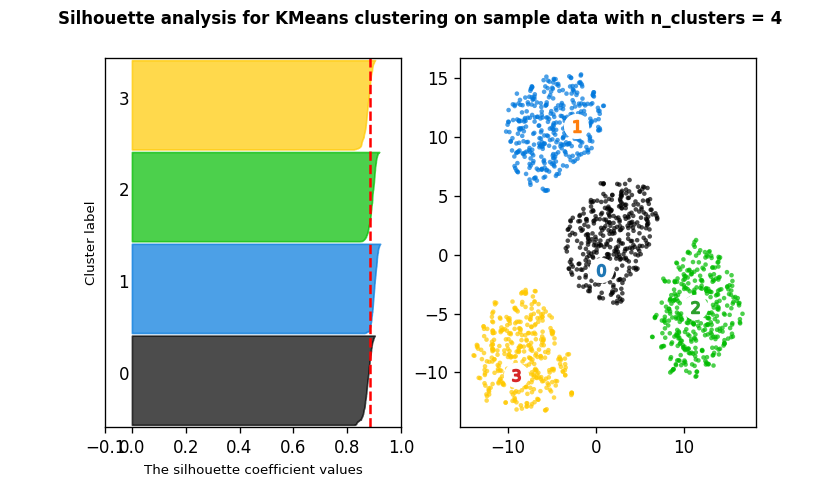

For n_clusters = 4 The average silhouette_score is : 0.885712318396


<IPython.core.display.Javascript object>


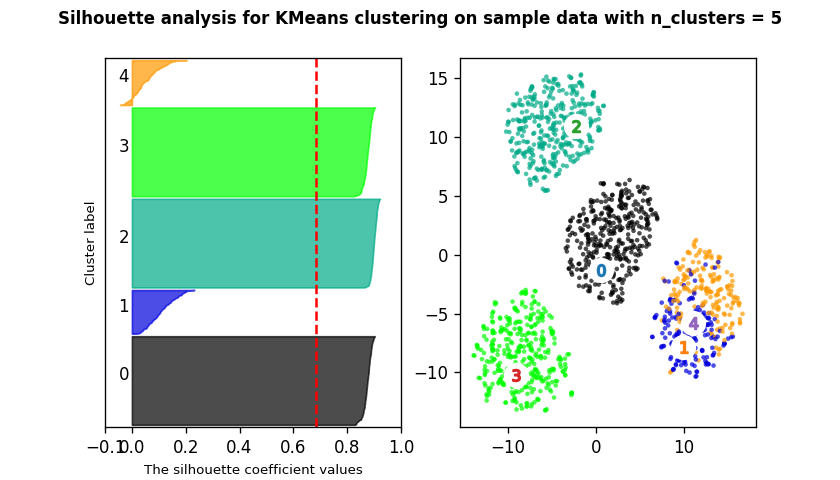

For n_clusters = 5 The average silhouette_score is : 0.682750078611


In [9]:
range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
    # fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.", fontsize=8)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=8)
    ax1.set_ylabel("Cluster label", fontsize=8)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y[:, 0], Y[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    closest, _ = metrics.pairwise_distances_argmin_min(centers, X)
    
    # Draw white circles at cluster centers
    # ax2.scatter(centers[:, 0], centers[:, 1],
    ax2.scatter(Y[closest, 0], Y[closest, 1],
                marker='o', c="white", alpha=1, s=200)

    # for i, c in enumerate(centers):
    # ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
    for i, c in enumerate(closest):
        ax2.scatter(Y[c, 0], Y[c, 1], marker='$%d$' % i, alpha=1, s=50)  

    #ax2.set_title("The visualization of the clustered data.", fontsize=8)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=10, fontweight='bold')
    #fig.tight_layout()
    plt.show()

## 3 Density-Based Algorithms

One of the problems of distance-based clustering is that the shape of underlying cluster is implicitly defined by the distance function. For example k-means assumes a spherical shape for the clusters. Density-Based clusters are very helpful in situation where the form and number of clusters is unknown. The idea is to first identify dense region in the data that forms the building blocks for constructing cluster of arbitrary shape.

### 3.1 DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

More formally, we define a core sample as being a sample in the dataset such that there exist `min_samples` other samples within a distance of `eps`, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples. Intuitively, these samples are on the fringes of a cluster.

Any core sample is part of a cluster, by definition. Any sample that is not a core sample, and is at least eps in distance from any core sample, is considered an outlier by the algorithm.

In the figure below, the color indicates cluster membership, with large circles indicating core samples found by the algorithm. Smaller circles are non-core samples that are still part of a cluster. Moreover, the outliers are indicated by black points below.

In [10]:
centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
X, _ = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                  random_state=0)

X = StandardScaler().fit_transform(X)

In [11]:
metrics.pairwise.pairwise_distances(X).mean()
pal = palettes.Category10[5]

In [12]:
db = DBSCAN(eps=0.3, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Silhouette Coefficient: 0.548


In [13]:
fig = bk.figure(plot_width=750, plot_height=450, 
                title='Estimated number of clusters: {}'.format(n_clusters_))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, pal):
    if k == -1:
        # Black used for noise.
        col = '#000000'
    
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    fig.scatter(xy[:, 0], xy[:, 1], fill_color=col, 
                line_color=None, size=14)

    xy = X[class_member_mask & ~core_samples_mask]
    fig.scatter(xy[:,0], xy[:,1], fill_color=col, 
                line_color=None, size=6)

fig.title.text_font_size = '14pt'
bk.show(fig)

## 4 Probabilistic Model-Based Algorithms 

The k-means clustering model explored before is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. In particular, the nonprobabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership may lead to poor performance in many real applications.

There’s another way to deal with clustering problems: a model-based approach, which consists in using certain models for clusters and attempting to optimize the fit between the data and the model.

In practice, each cluster can be mathematically represented by a parametric distribution, like a Gaussian (continuous) or a Poisson (discrete). The entire data set is therefore modelled by a mixture of these distributions. An individual distribution used to model a specific cluster is often referred to as a component distribution.

A mixture model with high likelihood tends to have the following traits:

* component distributions have high "peaks" (data in one cluster are tight);
* the mixture model "covers" the data well (dominant patterns in the data are captured by component distributions).

Main advantages of model-based clustering:

* well-studied statistical inference techniques available;
* flexibility in choosing the component distribution;
* obtain a density estimation for each cluster;
* a "soft" classification is available.

### 4.1 Mixture of Gaussians

In [14]:
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] 

In [15]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', zorder=2)

    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() 
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='lightblue', lw=3, alpha=0.5, zorder=1))

<IPython.core.display.Javascript object>


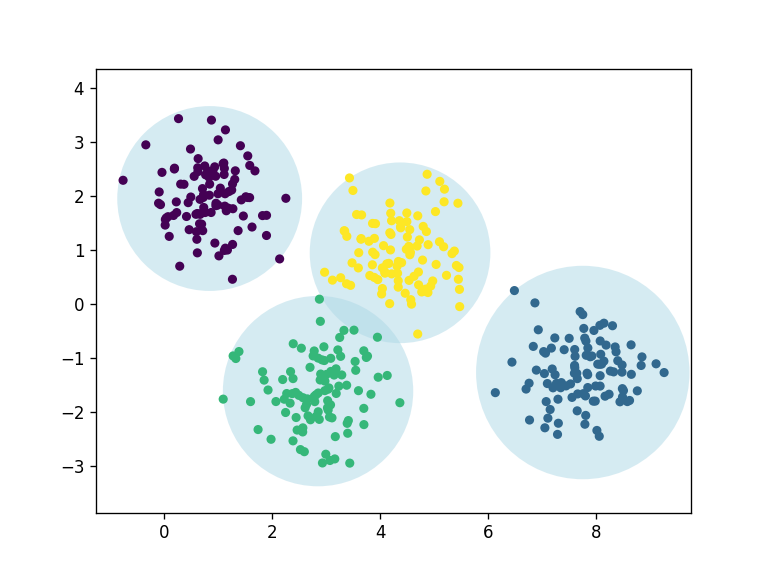

In [16]:
from scipy.spatial.distance import cdist
kmeans = KMeans(4, random_state=42)
labels = kmeans.fit(X).predict(X)
fig, ax = plt.subplots()
plot_kmeans(kmeans, X, ax)
fig.show()

<IPython.core.display.Javascript object>


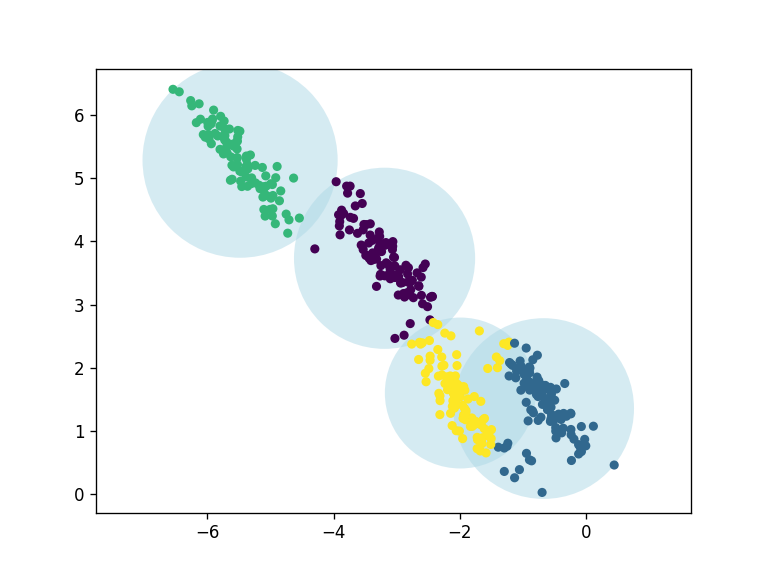

In [17]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
fig, ax = plt.subplots()
kmeans = KMeans(n_clusters=4, random_state=42)
plot_kmeans(kmeans, X_stretched, ax)
fig.show()

One possible solution is to use PCA or other transformations but since we are in an unsupervised environment there is no guarantee that it will work as expected. 

The most widely used clustering method for this kind of problems is the one based on learning a mixture of Gaussians: we can actually consider clusters as Gaussian distributions centred on their barycentres.

The GaussianMixture object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models, that qualitatively does the following:

1. Choose starting guesses for the location and shape

1. Repeat until converged:
    - E-step: for each point, find weights encoding the probability of membership in each cluster
    - M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

It can also draw confidence ellipsoids for multivariate models, and compute the Bayesian Information Criterion to assess the number of clusters in the data. A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the GaussianMixture.predict method.

The GaussianMixture comes with different options to constrain the covariance of the difference classes estimated: spherical, diagonal, tied or full covariance.

In [18]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

<IPython.core.display.Javascript object>


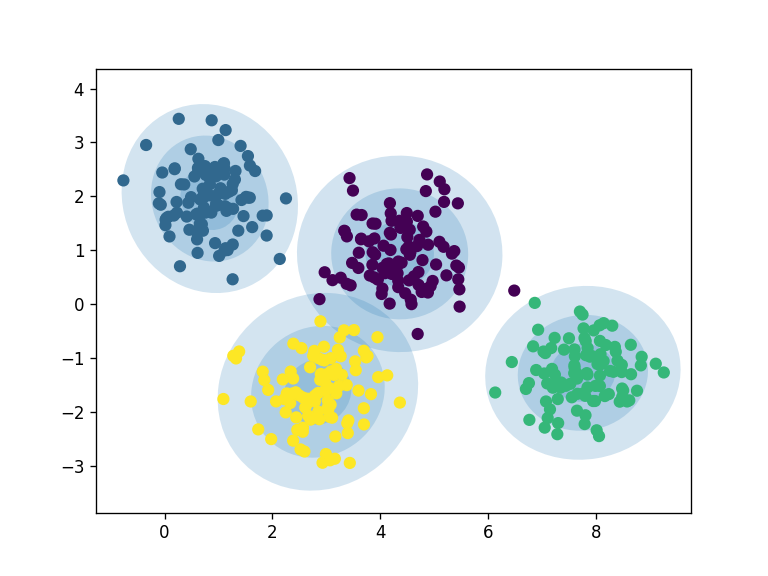

In [19]:
from sklearn.mixture import GaussianMixture
fig, ax = plt.subplots()
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X, ax)
fig.show()

<IPython.core.display.Javascript object>


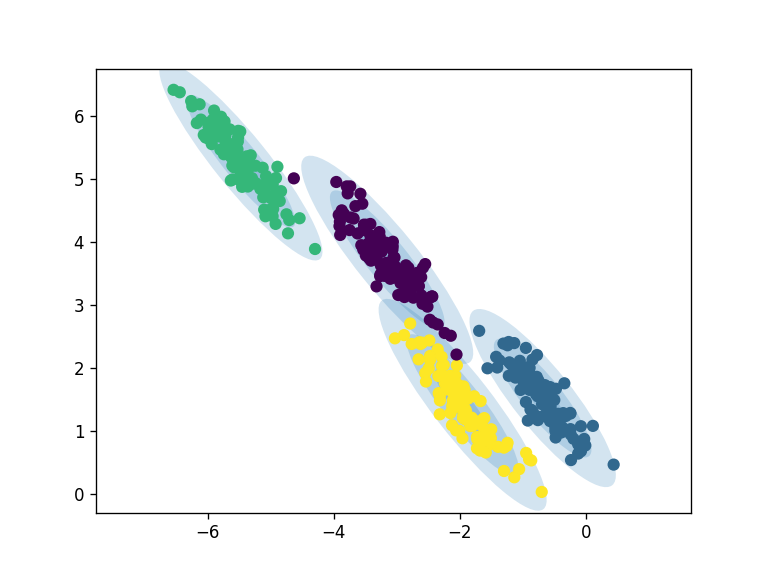

In [20]:
fig, ax = plt.subplots()
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched, ax)
fig.show()

*Choosing the covariance type:* If you look at the details of the preceding fits, you will see that the covariance_type option was set differently within each. This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. The default is covariance_type="diag" , which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is covariance_type="spherical" , which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full" , which allows each cluster to be modeled as an ellipse with arbitrary orientation.

The main difficulty in learning Gaussian mixture models from unlabeled data is that it is one usually doesn’t know which points came from which latent component (if one has access to this information it gets very easy to fit a separate Gaussian distribution to each set of points). Expectation-maximization is a well-founded statistical algorithm to get around this problem by an iterative process. First one assumes random components (randomly centered on data points, learned from k-means, or even just normally distributed around the origin) and computes for each point a probability of being generated by each component of the model. Then, one tweaks the parameters to maximize the likelihood of the data given those assignments. Repeating this process is guaranteed to always converge to a local optimum.



---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.